In [3]:
import numpy as np
import pandas as pd

path = "./ninapro_db1/Ninapro_DB1.csv"
df = pd.read_csv(path)

df.shape

(12553611, 39)

In [4]:
df.info(), df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12553611 entries, 0 to 12553610
Data columns (total 39 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0    int64  
 1   emg_0         float64
 2   emg_1         float64
 3   emg_2         float64
 4   emg_3         float64
 5   emg_4         float64
 6   emg_5         float64
 7   emg_6         float64
 8   emg_7         float64
 9   emg_8         float64
 10  emg_9         float64
 11  glove_0       float64
 12  glove_1       float64
 13  glove_2       float64
 14  glove_3       float64
 15  glove_4       float64
 16  glove_5       float64
 17  glove_6       float64
 18  glove_7       float64
 19  glove_8       float64
 20  glove_9       float64
 21  glove_10      float64
 22  glove_11      float64
 23  glove_12      float64
 24  glove_13      float64
 25  glove_14      float64
 26  glove_15      float64
 27  glove_16      float64
 28  glove_17      float64
 29  glove_18      float64
 30  glove_19      fl

(None,
 Index(['Unnamed: 0', 'emg_0', 'emg_1', 'emg_2', 'emg_3', 'emg_4', 'emg_5',
        'emg_6', 'emg_7', 'emg_8', 'emg_9', 'glove_0', 'glove_1', 'glove_2',
        'glove_3', 'glove_4', 'glove_5', 'glove_6', 'glove_7', 'glove_8',
        'glove_9', 'glove_10', 'glove_11', 'glove_12', 'glove_13', 'glove_14',
        'glove_15', 'glove_16', 'glove_17', 'glove_18', 'glove_19', 'glove_20',
        'glove_21', 'exercise', 'stimulus', 'restimulus', 'repetition',
        'rerepetition', 'subject'],
       dtype='object'))

In [5]:
emg_cols = [c for c in df.columns if "emg" in c.lower()]
df_emg = df[emg_cols]
df_emg.head()

,emg_0,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9
0,0.0024,0.0024,0.0024,0.0024,0.0024,0.0098,0.0146,0.0488,0.0024,0.0317
1,0.0024,0.0024,0.0024,0.0024,0.0024,0.0098,0.0122,0.0439,0.0024,0.0317
2,0.0024,0.0024,0.0024,0.0024,0.0024,0.0073,0.0073,0.0366,0.0024,0.0293
3,0.0049,0.0024,0.0024,0.0024,0.0024,0.0073,0.0049,0.0317,0.0024,0.0269
4,0.0049,0.0024,0.0024,0.0024,0.0024,0.0024,0.0024,0.0293,0.0024,0.0220


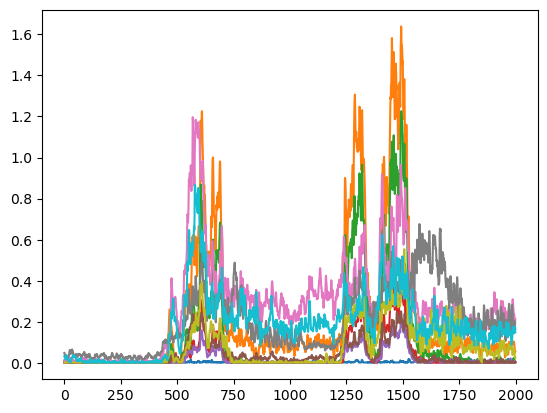

In [6]:
import matplotlib.pyplot as plt

plt.plot(df_emg.iloc[:2000])
plt.show()

In [7]:
df['stimulus'].unique(), df['repetition'].unique()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))

In [ ]:
from scipy import signal

def emg_filter_pipeline(x, fs, band=(20, 90), notch=60, smooth_lp=5.0, order=4, rectify=False):
    x = np.asarray(x, dtype=float)
    nyq = fs * 0.5

    def _filtfilt(b, a, sig):
        return signal.filtfilt(b, a, sig, axis=0, method="gust")

    # Bandpass
    low, high = band
    high = min(high, nyq * 0.999)               # keep strictly < Nyquist
    assert 0 < low < high < nyq, "Invalid band edges for given fs."
    b_bp, a_bp = signal.butter(order, [low/nyq, high/nyq], btype="band")
    y = _filtfilt(b_bp, a_bp, x)

    # Notch 60Hz
    if notch is not None:
        w0 = notch / nyq
        # Quality factor: higher Q = narrower notch (30–50 works well for EMG mains hum)
        b_notch, a_notch = signal.iirnotch(w0, Q=30)
        y = _filtfilt(b_notch, a_notch, y)

    # Rectifying
    if rectify:
        y = np.abs(y)

    # Smoothing
    if smooth_lp is not None:
        cutoff = min(smooth_lp, nyq * 0.999)
        b_lp, a_lp = signal.butter(order, cutoff/nyq, btype="low")
        y = _filtfilt(b_lp, a_lp, y)

    return y


def spectral_subtract_background(x, noise_bg, fs, nperseg=512, noverlap=384, oversub=1.0, floor=0.05):
    x = np.asarray(x, dtype=float)
    noise_bg = np.asarray(noise_bg, dtype=float)
    if x.ndim == 1:
        x = x[:, None]
    if noise_bg.ndim == 1:
        noise_bg = noise_bg[:, None]

    assert x.shape[1] == noise_bg.shape[1], "x and noise_bg must have same number of channels."

    y_out = np.zeros_like(x)
    win = signal.windows.hann(nperseg, sym=False)

    for c in range(x.shape[1]):
        f, t, Zx = signal.stft(x[:, c], fs=fs, window=win, nperseg=nperseg,
                               noverlap=noverlap, boundary=None)
        _, _, Zn = signal.stft(noise_bg[:, c], fs=fs, window=win, nperseg=nperseg,
                               noverlap=noverlap, boundary=None)

        mag_x = np.abs(Zx)
        phase_x = np.angle(Zx)
        # Average noise magnitude over time frames
        noise_mag = np.mean(np.abs(Zn), axis=1, keepdims=True)  # (F, 1)

        # Spectral subtraction
        clean_mag = mag_x - oversub * noise_mag
        # Flooring to avoid negative or too-small magnitudes
        clean_mag = np.maximum(clean_mag, floor * mag_x)

        # Reconstruct with original phase
        Z_clean = clean_mag * np.exp(1j * phase_x)
        _, y_c = signal.istft(Z_clean, fs=fs, window=win, nperseg=nperseg,
                              noverlap=noverlap, input_onesided=True, boundary=False)
        # Match length
        y_out[:len(y_c), c] = y_c

    return y_out.squeeze()


In [9]:
fs = 100 
# X_filtered = emg_filter_pipeline(df_emg.values, fs=fs, band=(20, 45), notch=50, smooth_lp=None, order=4, rectify=False)

def add_noise(x, noise=0.3):
    wn = np.random.rand(*x.shape) * noise * x.std(axis=0, keepdims=True)
    T = x.shape[0]
    t = np.linspace(0, 1, T)
    drift = (0.3*noise*x.std(axis=0, keepdims=True)) * np.sin(2*np.pi * 1 * t)[:, None]
    return x+wn+drift

# X_noised = add_noise(X_filtered, 0.3)

def window(sig, win_size, stride):
    windows = []
    for start in range(0, sig.shape[0] - win_size, stride):
        windows.append(sig[start:start+win_size])
    return np.stack(windows, axis=0)

win_size = 200
stride = 50

clean_win = window(emg_filter_pipeline(df[emg_cols].values, fs=fs, band=(20, 45), notch=50, smooth_lp=None, order=4, rectify=False), win_size, stride)
noise_win = window(add_noise(emg_filter_pipeline(df[emg_cols].values, fs=fs, band=(20, 45), notch=50, smooth_lp=None, order=4, rectify=False), 0.3), win_size, stride)

mean = clean_win.mean(axis=(0,1), keepdims=True)
std = clean_win.std(axis=(0,1), keepdims=True) + 1e-10

clean_win = (clean_win-mean)/std
noise_win = (noise_win-mean)/std

In [10]:
import torch
import torch.nn as nn
print(torch.backends.mps.is_available())

class Encoder(nn.Module):
    def __init__(self, input_shape):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv1d(input_shape, 32, kernel_size=3, padding='same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding='same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding='same')


        self.pool = nn.MaxPool1d(kernel_size=2)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(32)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.batch_norm3 = nn.BatchNorm1d(128)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):

        x = self.relu(self.batch_norm(self.conv1(x)))
        x = self.pool(x)

        x = self.relu(self.batch_norm2(self.conv2(x)))
        x = self.pool(x)

        x = self.relu(self.batch_norm3(self.conv3(x)))
        x = self.pool(x)
        return x


class Decoder(nn.Module):
    def __init__(self, input_shape):
        super(Decoder, self).__init__()

        self.deconv1 = nn.ConvTranspose1d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose1d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose1d(32, input_shape, kernel_size=3, stride=2, padding=1, output_padding=1)


        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(64)
        self.batch_norm2 = nn.BatchNorm1d(32)
        self.batch_norm3 = nn.BatchNorm1d(input_shape)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.batch_norm(self.deconv1(x)))
        x = self.relu(self.batch_norm2(self.deconv2(x)))
        x = self.relu(self.batch_norm3(self.deconv3(x)))
        return x


class Autoencoder(nn.Module):
    def __init__(self, input_shape):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_shape)
        self.decoder = Decoder(input_shape)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


True


In [14]:
# x = torch.tensor(clean_win, dtype=torch.float32).permute(0, 2, 1)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
n_channels = 10
model = Autoencoder(input_shape = n_channels).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
from torch.utils.data import Dataset, DataLoader

N = clean_win.shape[0]
idx = np.arange(N)
np.random.shuffle(idx)

train_ratio = 0.8
n_train = int(N * train_ratio)

train_idx = idx[:n_train]
val_idx   = idx[n_train:]

clean_train = clean_win[train_idx]
noise_train = noise_win[train_idx]

clean_val = clean_win[val_idx]
noise_val = noise_win[val_idx]

class EMGDenoiseDataset(Dataset):
    def __init__(self, noisy, clean):
        # noisy, clean: (N, T, C)
        self.noisy = torch.from_numpy(noisy).float()
        self.clean = torch.from_numpy(clean).float()

    def __len__(self):
        return self.noisy.shape[0]

    def __getitem__(self, i):
        # return as (C, T) for Conv1d
        x = self.noisy[i].permute(1, 0)  # (C, T)
        y = self.clean[i].permute(1, 0)  # (C, T)
        return x, y

train_ds = EMGDenoiseDataset(noise_train, clean_train)
val_ds   = EMGDenoiseDataset(noise_val,   clean_val)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False)

In [15]:
epochs = 10

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for n, c in train_loader:
        n = n.to(device)
        c = c.to(device)

        optimizer.zero_grad()

        y = model(n)
        loss = criterion(y, c)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * n.size(0)

    train_loss = train_loss / len(train_ds)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for noisy_batch, clean_batch in val_loader:
            noisy_batch = noisy_batch.to(device)
            clean_batch = clean_batch.to(device)

            outputs = model(noisy_batch)
            loss = criterion(outputs, clean_batch)
            val_loss += loss.item() * noisy_batch.size(0)

    val_loss /= len(val_ds)
    print(f"Epoch {epoch+1:02d} | train_loss={train_loss:.6f} | val_loss={val_loss:.6f}")


Epoch 01 | train_loss=0.755755 | val_loss=0.680702
Epoch 02 | train_loss=0.688099 | val_loss=0.658598
Epoch 03 | train_loss=0.667509 | val_loss=0.664521
Epoch 04 | train_loss=0.656617 | val_loss=0.640007
Epoch 05 | train_loss=0.649094 | val_loss=0.633268
Epoch 06 | train_loss=0.643984 | val_loss=0.634363
Epoch 07 | train_loss=0.639650 | val_loss=0.630813
Epoch 08 | train_loss=0.636677 | val_loss=0.630940
Epoch 09 | train_loss=0.634146 | val_loss=0.625677
Epoch 10 | train_loss=0.631955 | val_loss=0.629859


In [ ]:
model.eval()


Autoencoder(
  (encoder): Encoder(
    (conv1): Conv1d(10, 32, kernel_size=(3,), stride=(1,), padding=same)
    (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=same)
    (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=same)
    (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
    (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (deconv1): ConvTranspose1d(128, 64, kernel_size=(3,), stride=(2,), padding=(1,), output_padding=(1,))
    (deconv2): ConvTranspose1d(64, 32, kernel_size=(3,), stride=(2,), padding=(1,), output_padding=(1,))
    (deconv3): ConvTranspose1d(32, 10, kernel_size=(3,), str

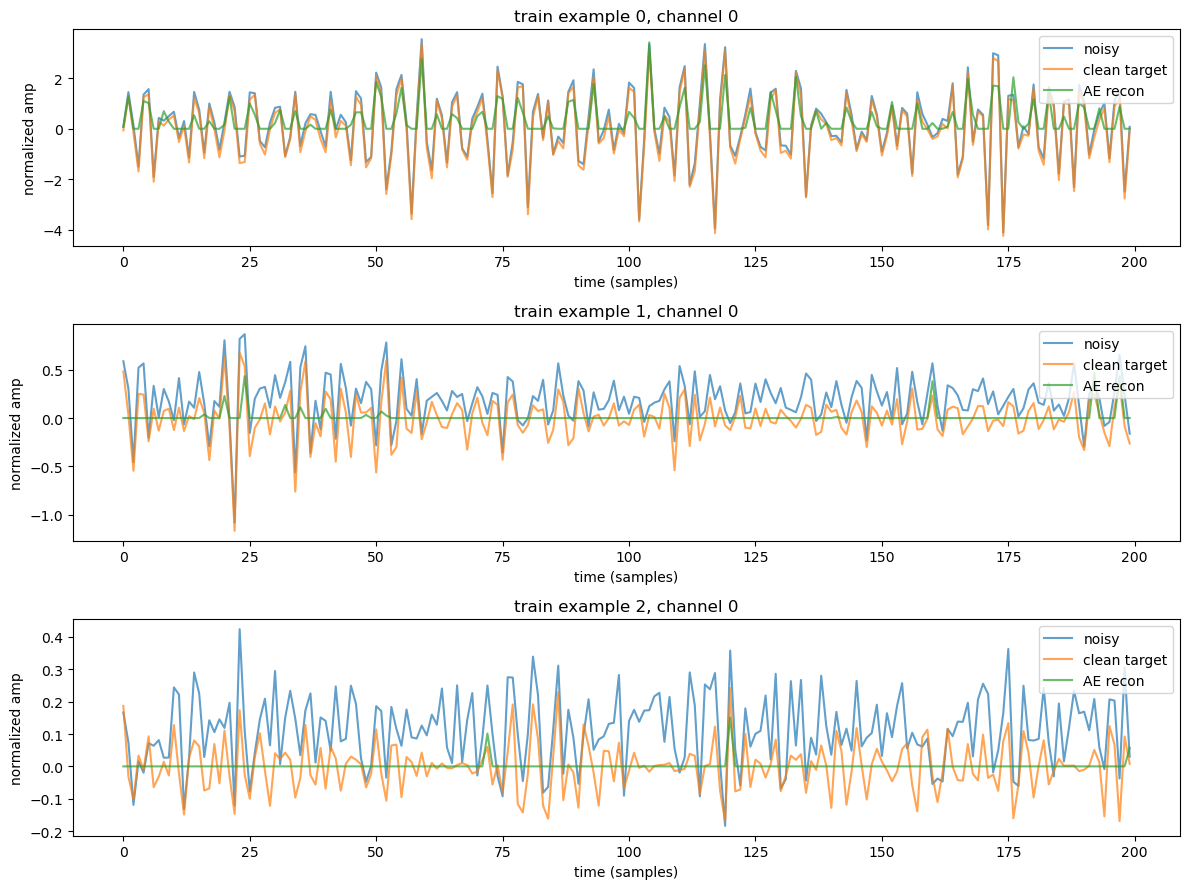

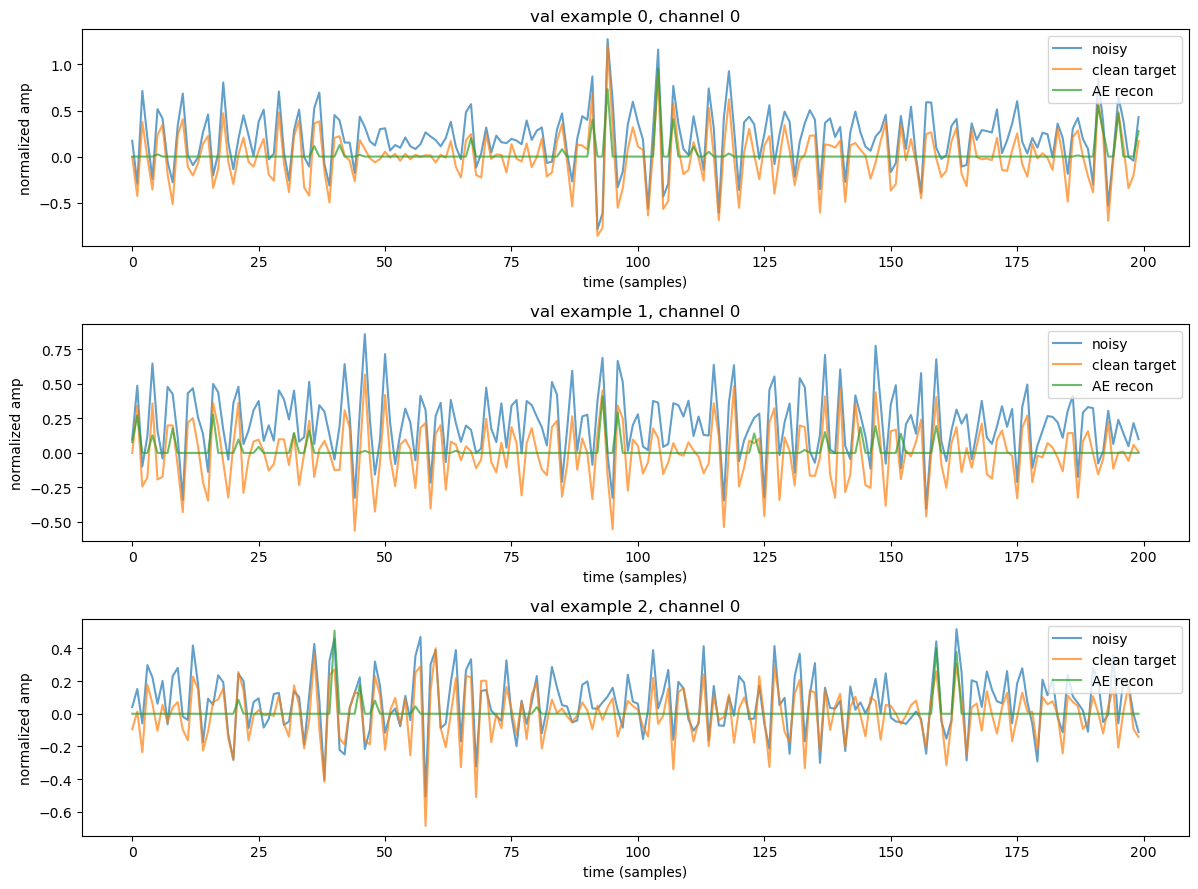

In [19]:
import matplotlib.pyplot as plt

def plot_reconstructions(model, loader, device, n_examples=3, channel=0, split_name="val"):
    model.eval()
    noisy_batch, clean_batch = next(iter(loader))
    noisy_batch = noisy_batch.to(device)   # (B, C, T)
    clean_batch = clean_batch.to(device)

    with torch.no_grad():
        recon_batch = model(noisy_batch)   # (B, C, T)

    noisy_batch = noisy_batch.cpu().numpy()
    clean_batch = clean_batch.cpu().numpy()
    recon_batch = recon_batch.cpu().numpy()

    B, C, T = noisy_batch.shape
    n_examples = min(n_examples, B)

    plt.figure(figsize=(12, 3 * n_examples))
    for i in range(n_examples):
        plt.subplot(n_examples, 1, i+1)
        plt.plot(noisy_batch[i, channel], label="noisy", alpha=0.7)
        plt.plot(clean_batch[i, channel], label="clean target", alpha=0.7)
        plt.plot(recon_batch[i, channel], label="AE recon", alpha=0.7)
        plt.title(f"{split_name} example {i}, channel {channel}")
        plt.xlabel("time (samples)")
        plt.ylabel("normalized amp")
        plt.legend(loc="upper right")
        plt.tight_layout()

    plt.show()

# Example usage:
plot_reconstructions(model, train_loader, device, n_examples=3, channel=0, split_name="train")
plot_reconstructions(model, val_loader,   device, n_examples=3, channel=0, split_name="val")